Let's get the data

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2121728/2110848 [==============================] - 2s 1us/step


Let's look at the data

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

We'll be using some of the training set for validation. The data is very similar to the IMDB set and follows the same concept. Note we also took the 10k most common words here.

In [4]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Let's process the data

In [10]:
import numpy as np
from keras.utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

The data is now ~9k vectors/1D tensors (1 axis) with 10k dimensions 

In [11]:
print(x_train.shape)

(8982, 10000)


Let's have a look at a translated data point:

In [24]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


This is a multiclass dataset. We want to know the category for the wire, of which there are 46 possibilities. So, we need a network that has at least that many (if possible more) nodes in the hidden layer, or otherwise some information will get dropped off if the network is too compact. We want to avoid bottlenecks in our network

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Create a validation set (first thousand training samples):

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Let's train:

In [16]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 256us/step - loss: 2.4886 - acc: 0.4932 - val_loss: 1.6812 - val_acc: 0.6500
Epoch 2/20
7982/7982 [==============================] - 2s 202us/step - loss: 1.3902 - acc: 0.7045 - val_loss: 1.2818 - val_acc: 0.7150
Epoch 3/20
7982/7982 [==============================] - 2s 207us/step - loss: 1.0476 - acc: 0.7711 - val_loss: 1.1183 - val_acc: 0.7660
Epoch 4/20
7982/7982 [==============================] - 2s 205us/step - loss: 0.8238 - acc: 0.8287 - val_loss: 1.0239 - val_acc: 0.7730
Epoch 5/20
7982/7982 [==============================] - 2s 203us/step - loss: 0.6594 - acc: 0.8633 - val_loss: 0.9741 - val_acc: 0.7940
Epoch 6/20
7982/7982 [==============================] - 2s 205us/step - loss: 0.5245 - acc: 0.8929 - val_loss: 0.9222 - val_acc: 0.8100
Epoch 7/20
7982/7982 [==============================] - 2s 204us/step - loss: 0.4288 - acc: 0.9116 - val_loss: 0.9158 - val_acc: 0.8010


Let's analyze the fit

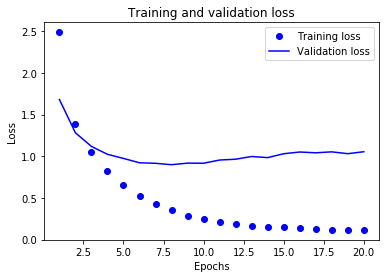

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Overfitting again. Looks like after around 6 epochs it stalls

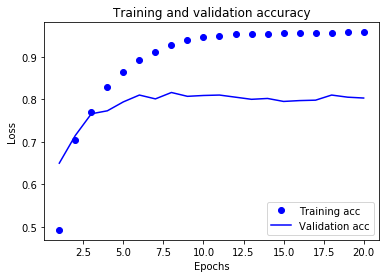

In [19]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Same for accuracy. Let's re-train and re-build the model.

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train, epochs=6, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/6
7982/7982 [==============================] - 2s 246us/step - loss: 2.5276 - acc: 0.5241 - val_loss: 1.6808 - val_acc: 0.6550
Epoch 2/6
7982/7982 [==============================] - 2s 219us/step - loss: 1.3731 - acc: 0.7139 - val_loss: 1.2813 - val_acc: 0.7210
Epoch 3/6
7982/7982 [==============================] - 2s 218us/step - loss: 1.0182 - acc: 0.7800 - val_loss: 1.1425 - val_acc: 0.7460
Epoch 4/6
7982/7982 [==============================] - 2s 220us/step - loss: 0.8039 - acc: 0.8242 - val_loss: 1.0626 - val_acc: 0.7570
Epoch 5/6
7982/7982 [==============================] - 2s 225us/step - loss: 0.6463 - acc: 0.8622 - val_loss: 0.9848 - val_acc: 0.7950
Epoch 6/6
7982/7982 [==============================] - 2s 221us/step - loss: 0.5188 - acc: 0.8913 - val_loss: 0.9162 - val_acc: 0.8090


Let's have a look:

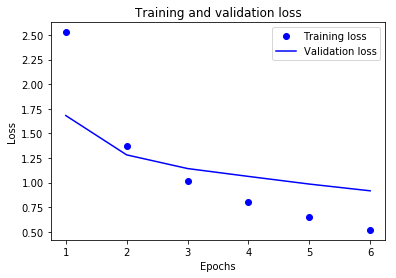

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

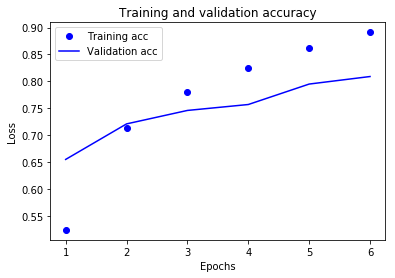

In [22]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()